In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from keras.layers.merge import Concatenate, add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
SEED       = 816  # Random seed
TRAIN_PATH = 'data/processed/train.json'
TEST_PATH  = 'data/processed/test.json'

BATCH_SIZE     = 32
EPOCHS         = 15 
EARLY_STOPPING = 7  # If model loss doesn't improve after this many iterations then stop

In [25]:
def build_model():
    
    image_input = Input(shape = (75, 75, 3), name = 'images')
    angle_input = Input(shape = [1], name = 'angle')
    activation = 'relu'
    bn_momentum = 0.99
    
    img_1 = BatchNormalization(momentum=bn_momentum)(image_input)
    img_1 = Conv2D(32, kernel_size=(3, 3), activation = activation, padding = 'same')(img_1)   
    img_1 = MaxPooling2D((2,2))(img_1)
    
    img_1 = Conv2D( 64, kernel_size = (3, 3), activation = activation, 
                    padding = 'same' ) ((BatchNormalization(momentum=bn_momentum)) (img_1) )
    img_1 = MaxPooling2D( (2,2), name='skip1' ) ( img_1 )
    
    # Residual block
    img_2 = Conv2D( 128, kernel_size = (3, 3), activation = activation, 
                    padding = 'same' ) ((BatchNormalization(momentum=bn_momentum)) (img_1))
    img_2 = Conv2D( 64, name='img2', kernel_size = (3, 3), 
                    activation = activation, padding = 'same' ) ( (BatchNormalization(momentum=bn_momentum)) (img_2) )
    
    img_2 = add( [img_1, img_2] )
    img_2 = MaxPooling2D( (2,2), name='skip2' ) ( img_2 )
    
    # Residual block
    img_3 = Conv2D( 128, kernel_size = (3, 3), activation = activation, 
                    padding = 'same' ) ((BatchNormalization(momentum=bn_momentum)) (img_2))
    img_3 = Conv2D( 64, name='img3', kernel_size = (3, 3), 
                    activation = activation, padding = 'same' ) ((BatchNormalization(momentum=bn_momentum)) (img_3))
    
    img_res = add( [img_2, img_3] )
    
    # Residual block
    img_4 = Conv2D( 128, kernel_size = (3, 3), activation = activation, 
                    padding = 'same' ) ((BatchNormalization(momentum=bn_momentum)) (img_3))
    img_4 = Conv2D( 64, name='img4', kernel_size = (3, 3), 
                    activation = activation, padding = 'same' ) ((BatchNormalization(momentum=bn_momentum)) (img_4))
    
    img_res = add( [img_2, img_3, img_4] )
    
    # Filter residual output
    img_res = Conv2D( 128, kernel_size = (3, 3), 
                      activation = activation ) ((BatchNormalization(momentum=bn_momentum)) (img_res))
    
    # Can you guess why we do this? Hint: Where did Flatten go??
    img_res = GlobalMaxPooling2D(name='global_pooling') ( img_res )
    
    # What is this? Hint: We have 2 inputs. An image and a number.
    cnn_out = Concatenate(name='What_happens_here')( [img_res, angle_input] )
    
    dense_layer = Dropout( 0.5 ) (Dense(256, activation = activation) (cnn_out)) 
    dense_layer = Dropout( 0.5 )  (Dense(64, activation = activation) (dense_layer)) 
    output = Dense( 1, activation = 'sigmoid' ) ( dense_layer )
    
    model = Model( [image_input, angle_input], output )
    
    opt = Adam( lr = 1e-3, beta_1 = .9, beta_2 = .999, decay = 1e-3 )

    model.compile( loss = 'binary_crossentropy', 
                   optimizer = opt, 
                   metrics = ['accuracy'] )

    model.summary()

    return model    

In [4]:
def get_callbacks(filepath, patience=2):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [msave,reduce_lr_loss]
file_path = ".baseline_resnet_weights.hdf5"
callbacks = get_callbacks(filepath=file_path)

In [10]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        #Create 3 bands having HH, HV and avg of both
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale, be carefull when testing cause it should do the same rescale to test data 
        #using mean, max and min value of train data
        #a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        #b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        #c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        #imgs.append(np.dstack((a, b, c)))
        
        imgs.append(np.dstack((band_1, band_2, band_3)))

    return np.array(imgs)

In [11]:
# This creates a Python iterator over the inputs
# It will run continually, but yield one batch at a time.
# So whenever you make the call to 'augment_data'
# it will return the next batch of data for you
def gen_flow( generator, X1, X2, y, batch_size = 32 ):
    generator_seed = np.random.randint( SEED )
    gen_X1 = generator.flow( X1, y, 
                             batch_size = batch_size, seed = generator_seed )
    gen_X2 = generator.flow( X1, X2, 
                             batch_size = batch_size, seed = generator_seed )

    while True:
        X1i = gen_X1.next()
        X2i = gen_X2.next()

        yield [ X1i[0], X2i[1] ], X1i[1]

In [12]:
from scipy.ndimage import rotate as rot

def augment(images):
    image_mirror_lr = []
    image_mirror_ud = []
    image_rotate = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        band_3 = images[i,:,:,2]
            
        # mirror left-right
        band_1_mirror_lr = np.flip(band_1, 0)
        band_2_mirror_lr = np.flip(band_2, 0)
        band_3_mirror_lr = np.flip(band_3, 0)
        image_mirror_lr.append(np.dstack((band_1_mirror_lr, band_2_mirror_lr, band_3_mirror_lr)))
        
        # mirror up-down
        band_1_mirror_ud = np.flip(band_1, 1)
        band_2_mirror_ud = np.flip(band_2, 1)
        band_3_mirror_ud = np.flip(band_3, 1)
        image_mirror_ud.append(np.dstack((band_1_mirror_ud, band_2_mirror_ud, band_3_mirror_ud)))
        
        #rotate 
        band_1_rotate = rot(band_1, 30, reshape=False)
        band_2_rotate = rot(band_2, 30, reshape=False)
        band_3_rotate = rot(band_3, 30, reshape=False)
        image_rotate.append(np.dstack((band_1_rotate, band_2_rotate, band_3_rotate)))
        
    mirrorlr = np.array(image_mirror_lr)
    mirrorud = np.array(image_mirror_ud)
    rotated = np.array(image_rotate)
    images = np.concatenate((images, mirrorlr, mirrorud, rotated))
    return images

In [13]:
# Read the angle data and replace NaN with 0 degrees
train_data = pd.read_json( TRAIN_PATH )
train_data[ 'inc_angle' ] = train_data[ 'inc_angle' ].replace('na', 0)
train_data[ 'inc_angle' ] = train_data[ 'inc_angle' ].astype(float).fillna(0.0)

indx_tr = np.where(train_data.inc_angle > 0)
print (indx_tr[0].shape)

#Generate the training data
X_train = get_scaled_imgs(train_data)
#X_test = get_scaled_imgs(test)
X_a = train_data[ 'inc_angle' ]
y_train=train_data['is_iceberg']

y_train = y_train[indx_tr[0]]
X_train = X_train[indx_tr[0], ...]
X_a = X_a[indx_tr[0]]

print (X_train.shape)
print (y_train.shape)
print(X_a.shape)

(1471,)
(1471, 75, 75, 3)
(1471,)
(1471,)


In [14]:
X_train, X_val, X_angle_train, X_angle_val, y_train, y_val = \
    train_test_split( X_train, X_a, y_train, 
                      train_size = .8, 
                      random_state = SEED )

E:\software\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [16]:
X_train_aug = augment(X_train)
y_train_aug = np.concatenate((y_train,y_train, y_train, y_train))
X_angle_train_aug = np.concatenate((X_angle_train, X_angle_train, X_angle_train, X_angle_train))

print (X_train_aug.shape)
print (y_train_aug.shape)
print(X_angle_train_aug.shape)

(4704, 75, 75, 3)
(4704,)
(4704,)


In [17]:
# Our data augmentation (applied to just the image)
image_augmentation = ImageDataGenerator( rotation_range = 20,
                                         horizontal_flip = True,
                                         vertical_flip = True,
                                         width_shift_range = .3,
                                         height_shift_range =.3,
                                         zoom_range = .1 )
train_generator = gen_flow( image_augmentation, X_train_aug, 
                                X_angle_train_aug, y_train_aug, 
                                batch_size = BATCH_SIZE )

In [26]:
# Define the ResNet model topology
model = build_model()

history = model.fit_generator( train_generator, 
                     steps_per_epoch = len(X_train)//BATCH_SIZE, 
                     epochs = 60,
                     callbacks = callbacks, verbose = 1, 
                     validation_data = [[X_val, X_angle_val], y_val] )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 75, 75, 3)    12          images[0][0]                     
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 75, 75, 32)   896         batch_normalization_8[0][0]      
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 37, 37, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
batch_norm

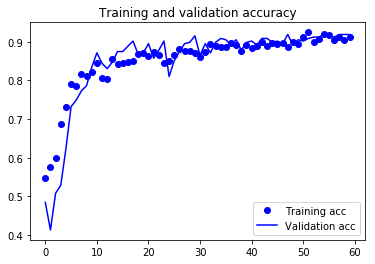

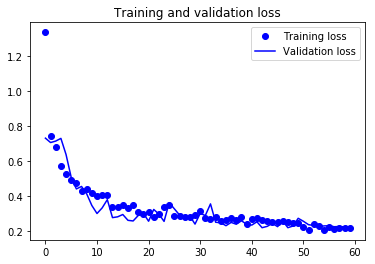

In [27]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [28]:
model.load_weights(filepath=file_path)

# Print the accuracy on the test set
val_score = model.evaluate( [X_val, X_angle_val], y_val, verbose = 1 )
print( 'Validation score: {:.3f}'.format(val_score[0]) )
print( 'Validation accuracy: {:.2f}%'.format(val_score[1]*100) )

295/295 [==============================] - 0s 395us/step
Validation score: 0.221
Validation accuracy: 90.85%


### Predict

In [22]:
test_data = pd.read_json( TEST_PATH )
X_test = get_scaled_imgs(test_data)

In [23]:
test_data[ 'inc_angle' ] = test_data[ 'inc_angle' ].replace('na', 0)
test_data[ 'inc_angle' ] = test_data[ 'inc_angle' ].astype(float).fillna(0.0)
X_test_ang = test_data[ 'inc_angle' ]

In [24]:
model.load_weights(filepath=file_path)

predicted_test=model.predict([X_test,X_test_ang])
submission = pd.DataFrame()
submission['id']=test_data['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('baseline_resnet.csv', index=False)

In [27]:
import tensorflow as tf
sess = tf.Session()
sess.close()
sess._closed
sess._opened

False